In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import bct

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot, paired_line_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from nctpy.energies import get_control_inputs, integrate_u
from nctpy.utils import normalize_state, matrix_normalization
from snaplab_tools.utils import get_schaefer_system_mask, get_null_p, get_fdr_p
from src.utils import get_yeo_control_set

from brainsmash.mapgen.base import Base

In [2]:
import psutil 
psutil.cpu_count(logical=True)

128

## Load data

In [3]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
outdir = '/home/lindenmp/research_projects/nct_xr/results'
fmri_concat = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat.npy'))
fmri_concat_subjidx = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat_subjidx.npy'))

In [4]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'schaefer400-7_centroids.csv'), index_col=0)
print(parc_centroids.head())

distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


In [5]:
system = 'continuous'
adjacency = np.load(os.path.join(indir, 'hcp_schaefer400-7_Am-features_schaefer_streamcount_areanorm_log.npy'))
adjacency_norm = matrix_normalization(adjacency, system=system)
n_nodes = adjacency.shape[0]

tmp_list = ['Default', 'SomMot', 'Cont', 'DorsAttn', 'SalVentAttn', 'Vis', 'Limbic']
ci = np.zeros(n_nodes)
for i in np.arange(len(tmp_list)):
    system_mask = get_schaefer_system_mask(list(parc_centroids.index), system=tmp_list[i])
    ci = ci + system_mask * (i + 1)

participation_coefficient = bct.participation_coef(adjacency, ci=ci, degree='undirected')
# participation_coefficient = participation_coefficient[np.diag(control_set == 1)]
participation_coefficient.shape

# participation_coefficient_matrix = np.zeros((n_nodes, n_nodes))
# for ii in np.arange(n_nodes):
#     for jj in np.arange(n_nodes):
#         participation_coefficient_matrix[ii, jj] = participation_coefficient[ii] - participation_coefficient[jj]

# participation_coefficient_matrix = participation_coefficient_matrix[np.diag(control_set == 1), :][:, np.diag(control_set == 1)]
# participation_coefficient_matrix.shape

(400,)

In [6]:
file_prefix = 'hcp-Am_optimal-'

n_states = 7
c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                            n_states, 
                                                                                                                                                            c, time_horizon, rho,
                                                                                                                                                            reference_state, init_weights,
                                                                                                                                                            n_steps, lr, eig_weight, reg_weight, reg_type)
print(file_str)
log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()
log_args.keys()

hcp-Am_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2


dict_keys(['state_trajectory', 'control_signals', 'numerical_error', 'control_energy', 'loss', 'eigen_values', 'optimized_weights', 'state_trajectory_variable_decay', 'control_signals_variable_decay', 'numerical_error_variable_decay', 'control_energy_variable_decay', 'state_trajectory_static_decay', 'numerical_error_static_decay', 'control_energy_static_decay', 'control_signals_corr_partial', 'control_energy_partial', 'numerical_error_partial', 'xfcorr_partial', 'control_signals_corr_partial_variable_decay', 'control_energy_partial_variable_decay', 'numerical_error_partial_variable_decay', 'xfcorr_partial_variable_decay', 'control_signals_system', 'control_signals_corr_system', 'control_energy_system', 'numerical_error_system', 'xfcorr_system', 'control_signals_system_variable_decay', 'control_signals_corr_system_variable_decay', 'control_energy_system_variable_decay', 'numerical_error_system_variable_decay', 'xfcorr_system_variable_decay'])

In [7]:
# load fMRI data
fmri_ts = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat.npy'))
fmri_ts_subjidx = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat_subjidx.npy'))

# load rsfMRI clusters
fmri_clusters_file = 'hcp_fmri_clusters_k-{0}.npy'.format(n_states)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']
labels = fmri_clusters['labels']
n_states = centroids.shape[0]
n_nodes = centroids.shape[1]
n_transitions = n_states * n_states
n_timepoints = time_horizon * 1000 + 1

n_labels = labels.shape[0]
print('n_states, {0}; n_labels, {1}; n_nodes, {2}'.format(n_states, n_labels, n_nodes))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_labels, 873600; n_nodes, 400


# Helper functions

In [8]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    return np.maximum(np.minimum(result, 1.0), -1.0)


def compute_control_sig_corr(control_signals):
    n_transitions = control_signals.shape[0]
    n_nodes = control_signals.shape[-1]

    control_signals_corr = np.zeros((n_transitions, n_nodes, n_nodes))
    for i in np.arange(n_transitions):
        # control_signals_corr[i] = np_pearson_cor(control_signals[i], control_signals[i])
        control_signals_corr[i] = np.corrcoef(control_signals[i].T)

    return control_signals_corr

# Control signals

In [9]:
log_args['control_signals'].shape

(7, 7, 1001, 400)

(49, 1001, 400) (49, 1001, 400)
INTuniform      0.862684
INToptimized    0.962247
dtype: float64
TtestResult(statistic=-13.22175621506295, pvalue=1.2838586852436609e-17, df=48)


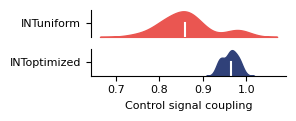

In [10]:
control_signals = log_args['control_signals'].reshape(n_transitions, n_timepoints, n_nodes)
control_signals_variable_decay = log_args['control_signals_variable_decay'].reshape(n_transitions, n_timepoints, n_nodes)
print(control_signals.shape, control_signals_variable_decay.shape)

control_signals_corr = compute_control_sig_corr(control_signals)
control_signals_variable_decay_corr = compute_control_sig_corr(control_signals_variable_decay)

my_colors = get_my_colors(cat_trio=True, as_list=True)

df_plot = pd.DataFrame()
x, y = [], []
for i in np.arange(n_transitions):
    x.append(np.abs(control_signals_corr[i][np.triu_indices(n_nodes, k=1)]).mean())
    y.append(np.abs(control_signals_variable_decay_corr[i][np.triu_indices(n_nodes, k=1)]).mean())
df_plot['INTuniform'] = x
df_plot['INToptimized'] = y
print(df_plot.mean())
print(sp.stats.ttest_rel(df_plot['INTuniform'], df_plot['INToptimized']))

df_plot = df_plot.melt()
df_plot.rename(columns={'value': 'Control signal coupling'}, inplace=True)
f = categorical_kde_plot(df=df_plot, variable='Control signal coupling', category='variable', horizontal=True, color_palette=my_colors, rug=False, fig_width=3, fig_height=1.25)
f.savefig(os.path.join(outdir, 'control_signals_self_corr.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

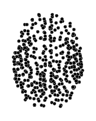

In [11]:
f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=np.ones(n_nodes),
                       vmin=0, vmax=1, add_colorbar=False, cmap='Grays')
f.savefig(os.path.join(outdir, 'uniform_full_control_set.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

## Partial control set

### Partial control set: random nodes

In [12]:
control_signals_corr_partial = log_args['control_signals_corr_partial']
control_energy_partial = log_args['control_energy_partial']
error_partial = log_args['numerical_error_partial']
xfcorr_partial = log_args['xfcorr_partial']

control_signals_corr_partial_variable_decay = log_args['control_signals_corr_partial_variable_decay']
control_energy_partial_variable_decay = log_args['control_energy_partial_variable_decay']
error_partial_variable_decay = log_args['numerical_error_partial_variable_decay']
xfcorr_partial_variable_decay = log_args['xfcorr_partial_variable_decay']

n_control_nodes = np.linspace(5, n_nodes-5, control_energy_partial.shape[2]).astype(int)
print(n_control_nodes)

[  5  12  20  28  36  44  52  60  68  76  84  92 100 108 116 124 132 140
 148 156 164 172 180 188 196 203 211 219 227 235 243 251 259 267 275 283
 291 299 307 315 323 331 339 347 355 363 371 379 387 395]


In [13]:
# legend_txt = ['INTuniform', 'INToptimized']
# f, ax = plt.subplots(4, 1, figsize=(3.5, 5))
# # f, ax = plt.subplots(3, 1, figsize=(10, 8))
# paired_line_plot(n_control_nodes, control_energy_partial.mean(axis=0).mean(axis=0), control_energy_partial_variable_decay.mean(axis=0).mean(axis=0), legend_txt[0], legend_txt[1], ax[2])
# ax[2].set_ylabel('Energy')
# ax[2].set_yscale('log')

# paired_line_plot(n_control_nodes, error_partial.mean(axis=0).mean(axis=0), error_partial_variable_decay.mean(axis=0).mean(axis=0), legend_txt[0], legend_txt[1], ax[1])
# ax[1].set_ylabel('Reconstruction error')
# ax[1].set_yscale('log')
# thr = 1e-2
# ax[1].axhline(y=thr, linestyle=':', c='gray')

# paired_line_plot(n_control_nodes, xfcorr_partial.mean(axis=0).mean(axis=0), xfcorr_partial_variable_decay.mean(axis=0).mean(axis=0), legend_txt[0], legend_txt[1], ax[0])
# vline_idx = n_control_nodes[np.where(xfcorr_partial.mean(axis=0).mean(axis=0).mean(axis=-1) > .99)[0][0]]
# print(vline_idx)
# ax[0].axvline(x=vline_idx, linestyle=':', c='gray')
# vline_idx = n_control_nodes[np.where(xfcorr_partial_variable_decay.mean(axis=0).mean(axis=0).mean(axis=-1) > .99)[0][0]]
# print(vline_idx)
# ax[0].axvline(x=vline_idx, linestyle=':', c='gray')
# ax[0].set_ylabel(r'$Pearson (x(T), x_{T})$')
# ax[0].legend()

# paired_line_plot(n_control_nodes, control_signals_corr_partial.mean(axis=0).mean(axis=0), control_signals_corr_partial_variable_decay.mean(axis=0).mean(axis=0), legend_txt[0], legend_txt[1], ax[3], plot_diff=False)
# # ax[3].set_ylabel('corr(x(T), xf)')

# # for this_ax in ax:
#     # this_ax.set_xlabel('number of random control nodes')
# ax[-1].set_xlabel('number of random control nodes')

# f.tight_layout()
# # f.savefig(os.path.join(outdir, 'control_energy_partial.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)v

### Partial control set: Yeo system

In [14]:
yeo_systems = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
# yeo_systems = ['Default', 'SomMot', 'Cont', 'DorsAttn', 'SalVentAttn', 'Vis', 'Limbic']
# yeo_systems = ['Default', 'SomMot', 'Cont', 'DorsAttn']
# yeo_systems = ['Cont', ]
# yeo_systems = ['Cont',]
n_systems = len(yeo_systems)

In [15]:
control_signals_corr_system = log_args['control_signals_corr_system']
control_energy_system = log_args['control_energy_system']
numerical_error_system = log_args['numerical_error_system']
xfcorr_system = log_args['xfcorr_system']

control_signals_corr_system_variable_decay = log_args['control_signals_corr_system_variable_decay']
control_energy_system_variable_decay = log_args['control_energy_system_variable_decay']
numerical_error_system_variable_decay = log_args['numerical_error_system_variable_decay']
xfcorr_system_variable_decay = log_args['xfcorr_system_variable_decay'] 

Cont
INTuniform      0.886640
INToptimized    0.738893
dtype: float64
TtestResult(statistic=12.79583479813026, pvalue=4.3976170501463496e-17, df=48)


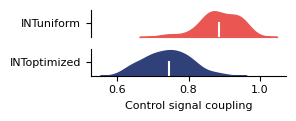

In [16]:
i = 5
print(yeo_systems[i])
my_colors = get_my_colors(cat_trio=True, as_list=True)

df_plot = pd.DataFrame()
x, y = [], []
for j in np.arange(n_transitions):
    x.append(control_signals_corr_system.reshape(n_transitions, n_systems)[j, i])
    y.append(control_signals_corr_system_variable_decay.reshape(n_transitions, n_systems)[j, i])
df_plot['INTuniform'] = x
df_plot['INToptimized'] = y
print(df_plot.mean())
print(sp.stats.ttest_rel(df_plot['INTuniform'], df_plot['INToptimized']))

df_plot = df_plot.melt()
df_plot.rename(columns={'value': 'Control signal coupling'}, inplace=True)
f = categorical_kde_plot(df=df_plot, variable='Control signal coupling', category='variable', horizontal=True, color_palette=my_colors, rug=False, fig_width=3, fig_height=1.25)
f.savefig(os.path.join(outdir, 'control_signals_system_self_corr.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)


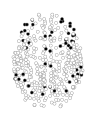

In [17]:
control_set = get_yeo_control_set(list(parc_centroids.index), yeo_systems[i], add_small_control=True)
f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=np.diag(control_set),
                       vmin=0, vmax=1, add_colorbar=False, cmap='Grays')
f.savefig(os.path.join(outdir, 'fpn_control_set.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

# Supplementary figures

In [18]:
i = 5
print(yeo_systems[i])
control_set_yeo = get_yeo_control_set(list(parc_centroids.index), yeo_systems[i], add_small_control=True)
control_signals_system_variable_decay = log_args['control_signals_system_variable_decay']

Cont


(52, 52)


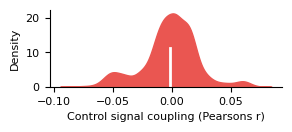

In [19]:
corr_old_new = np_pearson_cor(control_signals_variable_decay.mean(axis=0)[:, np.diag(control_set_yeo == 1)], control_signals_system_variable_decay.mean(axis=0).mean(axis=0)[:, np.diag(control_set_yeo == 1), i])
print(corr_old_new.shape)

f, ax = plt.subplots(1, 1, figsize=(3, 1))
plot_data = corr_old_new[np.triu_indices(corr_old_new.shape[0], k=1)]
sns.kdeplot(plot_data, color=my_colors[0], bw_adjust=1, fill=True, alpha=1, linewidth=1, ax=ax)
sns.despine(ax=ax)
ax.axvline(x=plot_data.mean(), ymax=0.5, color='white', linewidth=2)
ax.set_xlabel('Control signal coupling (Pearsons r)')
f.savefig(os.path.join(outdir, 'fpn_control_signals_corr_with_uniform.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)